In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from orthogonal_dfa.experiments.gate_experiments import train_many
from orthogonal_dfa.module.rnn import RNNProcessor, LSTMProcessor

In [4]:
constructors = {
    "RNN": lambda length: RNNProcessor(
        num_inputs=4, hidden_size=100, num_layers=2
    ).cuda(),
    "LSTM": lambda length: LSTMProcessor(
        num_inputs=4, hidden_size=100, num_layers=2
    ).cuda(),
}

In [5]:
def train_and_evaluate(constructor, batch_norm):
    ev_by_finetune = {}
    for finetune_epochs in 0, 25:
        _, [tr], [ev] = train_many(
            constructor,
            1,
            seed=0,
            epochs=500,
            lr=1e-5,
            batch_norm=batch_norm,
            finetune_epochs=finetune_epochs,
        )
        tr, ev = 1000 * -np.array(tr).mean(-1), 1000 * ev
        ev_by_finetune[finetune_epochs != 0] = ev
    return tr, ev_by_finetune

In [6]:
results = {
    k + (" [no batch]" if not batch_norm else ""): train_and_evaluate(c, batch_norm)
    for k, c in constructors.items()
    for batch_norm in (True, False)
}

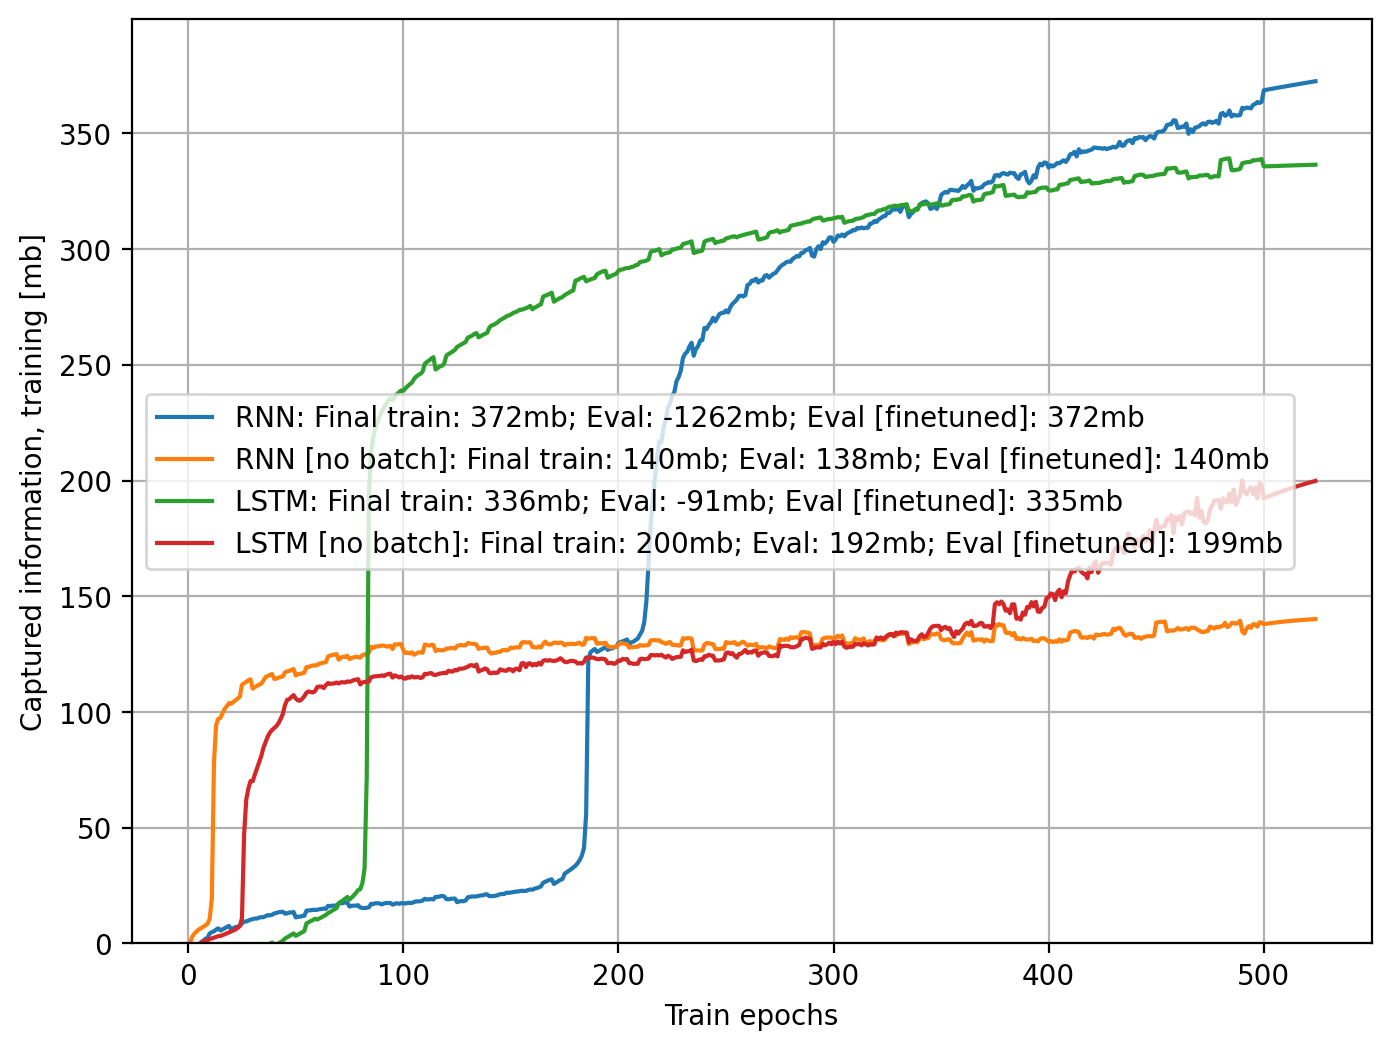

In [7]:
plt.figure(dpi=200, figsize=(8, 6))
for k, (tr, ev) in results.items():
    plt.plot(
        tr,
        label=f"{k}: Final train: {tr[-1]:.0f}mb; Eval: {ev[False]:.0f}mb; Eval [finetuned]: {ev[True]:.0f}mb",
    )
plt.legend()
plt.ylim(0, plt.ylim()[1])
plt.grid()
plt.xlabel("Train epochs")
plt.ylabel("Captured information, training [mb]")
plt.show()